# CIFAR10 Classfier: Keras Tuner Edition

In the previous notebook, we manually tuned the hyper parameters to improve the test accuracy. We are now going to make use of Keras Tuner library to perform hypertuning.

Best Validation Accuracy with manually tuning: 67.4%
We are going to use that as our baseline.

Can we beat that?


Author: Katnoria | Created: 17-Aug-2020 | Updated: 

In [1]:
import pickle
from time import time
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model
import IPython
import kerastuner as kt

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [5]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [6]:

IMG_SIZE = 32
NUM_CLASSES = metadata.features["label"].num_classes
print(f"Classes: {NUM_CLASSES}")

Classes: 10


In [7]:
IMG_SIZE = 32
# test
train_ds = ds_train \
    .cache() \
    .batch(1, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

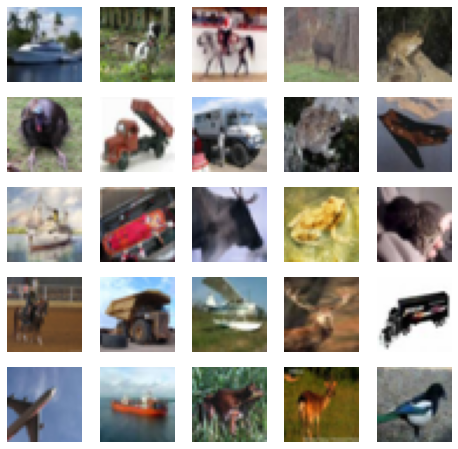

In [8]:
examples = ds_train.take(64)

fig, axs = plt.subplots(5, 5, figsize=(8,8))

for record, ax in zip(examples, axs.flat):
    image, _ = record
    ax.imshow(image)
    ax.axis('off')
plt.show()    

In [9]:
# we no longer need it
del train_ds

In [10]:
# Base Model
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

# Data Augmentation

In [11]:
# def transforms(x, hp):
#     use_rotation = hp.Boolean('use_rotation')
#     if use_rotation:
#         x = tf.keras.layers.experimental.preprocessing.RandomRotation(
#             hp.Float('rotation_factor', min_value=0.05, max_value=0.2)
#         )(x)

#     use_flip = hp.Boolean('use_flip')
#     if use_flip:
#         tf.keras.layers.experimental.preprocessing.RandomFlip(
#           hp.Choice('orientation', values=['vertical', 'horizontal', 'horizontal_and_vertical'])
#         )(x)

#     #   use_zoom = hp.Boolean('use_zoom')
#     #   if use_zoom:
#     #     x = tf.keras.layers.experimental.preprocessing.RandomZoom(
#     #         hp.Float('use_zoom', min_value=0.05, max_value=0.2)
#     #     )(x)

#     return x

# Without making any changes to image augmentation
transforms = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
  # Load dataset
(ds_train, ds_test), metadata = tfds.load(
  'cifar10', split=['train', 'test'], shuffle_files=True, 
  with_info=True, as_supervised=True
  )

In [13]:
num_train_examples=len(ds_train)

In [14]:
# create train and test batch
BS = 128
train_ds = ds_train \
  .cache() \
  .shuffle(num_train_examples).batch(BS, drop_remainder=True) \
  .prefetch(tf.data.experimental.AUTOTUNE) 
  
test_ds = ds_test \
    .cache() \
    .batch(BS, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE)       


In [15]:
from kerastuner import HyperModel

class BasicResnet50Model(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def build(self, hp):
        inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = transforms(inputs)
        x = tf.keras.applications.resnet.preprocess_input(x)
        x = base_model(x, training=False)
        x = Flatten()(x)          
        
        hp_activation = hp.Choice('activation', values=['relu', 'selu', 'elu'])  
        hp_drop_rate = hp.Float('rate', min_value=0.0, max_value=0.8, step=0.2) 
        # the line below will increase your search space significantly
        # you can change it to choice or sample?
#         num_dense_units = hp.Int('units', min_value=64, max_value=512, step=32)
        num_dense_units = hp.Choice('units', [64, 128, 256, 512])
        x = Dense(num_dense_units, activation=hp_activation)(x)
        x = Dropout(hp_drop_rate)(x)        
        outputs = Dense(NUM_CLASSES)(x)    
        model = tf.keras.Model(inputs, outputs)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(
          optimizer=tf.keras.optimizers.Adam(hp_learning_rate),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
          )

        return model

In [16]:
# def model_builder(hp):
#     inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))    
# #     x = transforms(inputs, hp)
#     x = transforms(inputs)
#     x = tf.keras.applications.resnet.preprocess_input(x)
#     x = base_model(x, training=False)
#     hp_num_filters = hp.Int('filters', min_value=32, max_value=512, step=32)
#     hp_activation = hp.Choice('activation', val1ues=['relu', 'selu', 'elu'])  
#     x = Conv2D(hp_num_filters, 2, padding='same', input_shape=(1,1,2048), activation=hp_activation)(x)
#     hp_drop_rate = hp.Float('rate', min_value=0.1, max_value=0.8, step=0.1)  
#     x = Dropout(hp_drop_rate)(x)
#     x = GlobalAveragePooling2D()(x)  
#     x = Dropout(hp_drop_rate)(x)
#     use_dense = hp.Boolean('use_dense')
#     if use_dense:
#         num_dense_units = hp.Int('units', min_value=32, max_value=1024, step=32)
#         x = Dense(num_dense_units)(x)
#         x = Dropout(hp_drop_rate)(x)        
#     outputs = Dense(NUM_CLASSES)(x)    
#     model = tf.keras.Model(inputs, outputs)

#     hp_learning_rate = hp.Float('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(
#       optimizer=tf.keras.optimizers.Adam(hp_learning_rate),
#       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#       metrics=['accuracy']
#       )

#     return model

In [17]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

# Tuner: Random Search

Next, we also give random search a shot. There are other tuners available. You can find the complete list [here](https://keras-team.github.io/keras-tuner/documentation/tuners/)

In [18]:
# instantiate the model
basic_resnet_model = BasicResnet50Model(10)
# define the tuner
tuner = kt.tuners.RandomSearch(
    basic_resnet_model,
    objective='val_accuracy',
    max_trials=100,
    overwrite=True,
    project_name = 'cifar10-kt-randomsearch',
)

callbacks = [
             tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, baseline=0.9),
             ClearTrainingOutput()
             ]

In [19]:
# go search
start = time()
print(f"start: {datetime.fromtimestamp(start)}")
tuner.search(train_ds, epochs=25, callbacks=callbacks, validation_data=train_ds, verbose=0)
stop = time()

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [20]:
took = stop - start
print(f"Total training time: {took//60 : .0f}m {took%60:.0f}s")

Total training time:  51m 27s


### Evaluate

We will now evaluate the best model on the test set.

In [22]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'activation': 'selu', 'rate': 0.2, 'units': 128, 'learning_rate': 0.001}

In [23]:
# best_model = tuner.get_best_models(1)[0]
best_model.evaluate(test_ds)

78/78 [==============================] - ETA: 0s - loss: 1.1516 - accuracy: 0.59 - ETA: 0s - loss: 1.0790 - accuracy: 0.62 - ETA: 0s - loss: 1.1237 - accuracy: 0.60 - ETA: 0s - loss: 1.1440 - accuracy: 0.60 - ETA: 0s - loss: 1.1623 - accuracy: 0.59 - ETA: 0s - loss: 1.1697 - accuracy: 0.59 - ETA: 0s - loss: 1.1745 - accuracy: 0.59 - ETA: 0s - loss: 1.1811 - accuracy: 0.59 - ETA: 0s - loss: 1.1835 - accuracy: 0.58 - ETA: 0s - loss: 1.1864 - accuracy: 0.58 - ETA: 0s - loss: 1.1856 - accuracy: 0.58 - ETA: 0s - loss: 1.1897 - accuracy: 0.57 - ETA: 0s - loss: 1.1905 - accuracy: 0.58 - ETA: 0s - loss: 1.1875 - accuracy: 0.58 - ETA: 0s - loss: 1.1841 - accuracy: 0.58 - ETA: 0s - loss: 1.1836 - accuracy: 0.58 - 1s 12ms/step - loss: 1.1849 - accuracy: 0.5864


[1.184916377067566, 0.5864382982254028]

**Test Accuracy: 58.6% 😏**

# Hyperband

Let us try another tuner that speeds up the random search using adaptive resource allocation and early stopping. [Ref](https://arxiv.org/abs/1603.06560)

In [24]:
# instantiate the model
basic_resnet_model = BasicResnet50Model(10)
# define the tuner
tuner = kt.Hyperband(
    basic_resnet_model, objective='val_accuracy',  
    max_epochs = 50, factor = 3, project_name = 'cifar10-dense-hb'
    )

In [25]:
# go search
start = time()
print(f"start: {datetime.fromtimestamp(start)}")
tuner.search(
    train_ds, epochs = 25, validation_data = test_ds, verbose=0,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=3), ClearTrainingOutput()]
    )
end = time()

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [26]:
took = end - start
print(f"Total training time: {took//60 : .0f}m {took%60:.0f}s")

Total training time:  59m 9s


In [29]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'activation': 'selu',
 'rate': 0.2,
 'units': 512,
 'learning_rate': 0.0001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': 'd5072d2545b2d44568010906158d7787'}

### Checkpointing

We do not need to manually save the best model or hyper param. Keras-Tuner records every trial and you can just load it back using the same command used above.

Test: Restart the notebook, do not run the trial and execute the cells below

In [30]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [31]:
best_hyperparameters.values

{'activation': 'selu',
 'rate': 0.2,
 'units': 512,
 'learning_rate': 0.0001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': 'd5072d2545b2d44568010906158d7787'}

### Evaluate

Let's evaluate the best model against the test set

In [32]:
best_model.evaluate(test_ds)

78/78 [==============================] - ETA: 0s - loss: 1.2720 - accuracy: 0.55 - ETA: 0s - loss: 1.0580 - accuracy: 0.64 - ETA: 0s - loss: 1.0864 - accuracy: 0.62 - ETA: 0s - loss: 1.0900 - accuracy: 0.62 - ETA: 0s - loss: 1.0986 - accuracy: 0.62 - ETA: 0s - loss: 1.1125 - accuracy: 0.61 - ETA: 0s - loss: 1.1194 - accuracy: 0.62 - ETA: 0s - loss: 1.1254 - accuracy: 0.61 - ETA: 0s - loss: 1.1216 - accuracy: 0.61 - ETA: 0s - loss: 1.1223 - accuracy: 0.61 - ETA: 0s - loss: 1.1190 - accuracy: 0.61 - ETA: 0s - loss: 1.1231 - accuracy: 0.61 - ETA: 0s - loss: 1.1231 - accuracy: 0.61 - ETA: 0s - loss: 1.1220 - accuracy: 0.61 - ETA: 0s - loss: 1.1205 - accuracy: 0.61 - ETA: 0s - loss: 1.1226 - accuracy: 0.61 - 1s 12ms/step - loss: 1.1224 - accuracy: 0.6138


[1.1223784685134888, 0.6137820482254028]

**The best test accuracy is 61.4%, which is still not good enough**

Keras-Tuner also supports bayesian optimization to search the best model (BayesianOptimization Tuner). You could give it a try too.

## Conclusion

We saw how to use keras-tuner to perform the hyper-param search. In the end, we could not beat our baseline.

Here are a few things that we could have tried:
- image augmentation search
- increase the number of epochs (Warning: 100 will take a long time)
- search the pooling options (Global Average, Global Max Pooling)
- add batchnorm?
- full architecture search (i.e do not use backbone/pretrained networks)

Play around with the search space and see if you can beat the baseline. If all else fails, here is where you can look for inspiration.

*Hint: This [one](https://github.com/keras-team/keras-tuner/blob/master/examples/cifar10.py) from keras-team does the full architecture search (i.e. no pretrained networks) and achieves 80% test accuracy.*

Can you beat it?